## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import AlbertTokenizer
import transformers

from text_data import TextDataset5
from albert import CustomAlbert
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
%%time
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 11.8 s, sys: 119 ms, total: 11.9 s
Wall time: 12.3 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_albert_1'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.a_albert, lr / 100, weight_decay)
        + get_optimizer_param_groups(model.q_albert, lr / 100, weight_decay)
    )

There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


Fold 1 started at Thu Feb  6 07:53:47 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


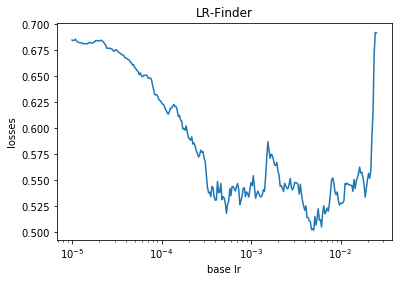

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50397 - spearmanr 0.25481
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47611 - spearmanr 0.37107


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.37107
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46013 - spearmanr 0.38204
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45471 - spearmanr 0.40894
best model: epoch 1 - 0.40894
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43573 - spearmanr 0.45085
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45341 - spearmanr 0.4155
best model: epoch 2 - 0.4155
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41007 - spearmanr 0.51615
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45783 - spearmanr 0.41022
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41550
Starting inference for model: checkpoints/siamese_albert_1_fold_1_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_1_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 2 started at Thu Feb  6 08:32:55 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50405 - spearmanr 0.25286
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47073 - spearmanr 0.3818
best model: epoch 0 - 0.3818
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45889 - spearmanr 0.38431
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46002 - spearmanr 0.41103
best model: epoch 1 - 0.41103
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43389 - spearmanr 0.45356
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45326 - spearmanr 0.42492
best model: epoch 2 - 0.42492
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40705 - spearmanr 0.51995
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45505 - spearmanr 0.42116
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42492
Starting inference for model: checkpoints/siamese_albert_1_fold_2_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_2_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 3 started at Thu Feb  6 09:10:42 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50362 - spearmanr 0.25823
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47143 - spearmanr 0.37424
best model: epoch 0 - 0.37424
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45931 - spearmanr 0.38324
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46072 - spearmanr 0.39734
best model: epoch 1 - 0.39734
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.4347 - spearmanr 0.45139
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45569 - spearmanr 0.40719
best model: epoch 2 - 0.40719
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40866 - spearmanr 0.5179
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4569 - spearmanr 0.40535
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40719
Starting inference for model: checkpoints/siamese_albert_1_fold_3_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_3_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 4 started at Thu Feb  6 09:48:29 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50315 - spearmanr 0.25702
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47114 - spearmanr 0.3661
best model: epoch 0 - 0.3661
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45868 - spearmanr 0.38773
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45675 - spearmanr 0.39444
best model: epoch 1 - 0.39444
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43428 - spearmanr 0.45389
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45362 - spearmanr 0.40319
best model: epoch 2 - 0.40319
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40753 - spearmanr 0.5212
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.456 - spearmanr 0.40277
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40319
Starting inference for model: checkpoints/siamese_albert_1_fold_4_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_4_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 5 started at Thu Feb  6 10:26:16 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50392 - spearmanr 0.25884
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46954 - spearmanr 0.37255
best model: epoch 0 - 0.37255
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45925 - spearmanr 0.38668
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45486 - spearmanr 0.39184
best model: epoch 1 - 0.39184
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43539 - spearmanr 0.45117
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45228 - spearmanr 0.39831
best model: epoch 2 - 0.39831
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41099 - spearmanr 0.51255
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45439 - spearmanr 0.40065
best model: epoch 3 - 0.40065
TRAINING END: Best score achieved on epoch 3 - 0.40065
Starting inference for model: checkpoints/siamese_albert_1_fold_5_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_5_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 6 started at Thu Feb  6 11:04:04 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50401 - spearmanr 0.25777
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.4666 - spearmanr 0.3645
best model: epoch 0 - 0.3645
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45955 - spearmanr 0.38572
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45274 - spearmanr 0.39462
best model: epoch 1 - 0.39462
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43527 - spearmanr 0.45253
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45151 - spearmanr 0.39688
best model: epoch 2 - 0.39688
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40883 - spearmanr 0.52022
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45279 - spearmanr 0.39706
best model: epoch 3 - 0.39706
TRAINING END: Best score achieved on epoch 3 - 0.39706
Starting inference for model: checkpoints/siamese_albert_1_fold_6_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_6_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 7 started at Thu Feb  6 11:41:54 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50341 - spearmanr 0.25625
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47835 - spearmanr 0.36468
best model: epoch 0 - 0.36468
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45964 - spearmanr 0.38238
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46287 - spearmanr 0.39725
best model: epoch 1 - 0.39725
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43435 - spearmanr 0.45194
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45821 - spearmanr 0.41314
best model: epoch 2 - 0.41314
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4076 - spearmanr 0.51867
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45807 - spearmanr 0.41585
best model: epoch 3 - 0.41585
TRAINING END: Best score achieved on epoch 3 - 0.41585
Starting inference for model: checkpoints/siamese_albert_1_fold_7_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_7_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 8 started at Thu Feb  6 12:19:46 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.5042 - spearmanr 0.25187
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47941 - spearmanr 0.37451
best model: epoch 0 - 0.37451
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45862 - spearmanr 0.38272
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4689 - spearmanr 0.40679
best model: epoch 1 - 0.40679
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43381 - spearmanr 0.4526
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45947 - spearmanr 0.41887
best model: epoch 2 - 0.41887
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40739 - spearmanr 0.51842
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46351 - spearmanr 0.41627
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41887
Starting inference for model: checkpoints/siamese_albert_1_fold_8_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_8_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 9 started at Thu Feb  6 12:57:36 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50348 - spearmanr 0.25909
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47153 - spearmanr 0.36539
best model: epoch 0 - 0.36539
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45821 - spearmanr 0.3874
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45828 - spearmanr 0.39502
best model: epoch 1 - 0.39502
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.4352 - spearmanr 0.45238
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45377 - spearmanr 0.40754
best model: epoch 2 - 0.40754
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40904 - spearmanr 0.51832
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45333 - spearmanr 0.41308
best model: epoch 3 - 0.41308
TRAINING END: Best score achieved on epoch 3 - 0.41308
Starting inference for model: checkpoints/siamese_albert_1_fold_9_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_9_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 10 started at Thu Feb  6 13:35:30 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50559 - spearmanr 0.25482
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47456 - spearmanr 0.37658
best model: epoch 0 - 0.37658
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.46016 - spearmanr 0.38294
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.44798 - spearmanr 0.4091
best model: epoch 1 - 0.4091
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43552 - spearmanr 0.45157
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44356 - spearmanr 0.41924
best model: epoch 2 - 0.41924
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40852 - spearmanr 0.51913
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4457 - spearmanr 0.42023
best model: epoch 3 - 0.42023
TRAINING END: Best score achieved on epoch 3 - 0.42023
Starting inference for model: checkpoints/siamese_albert_1_fold_10_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_10_best.pth



OOF score: 0.40970506429919773


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomAlbert(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [12]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 8 0.46693244233826214
5 4 0.4503756531681175
9 64 0.1162576171883871
11 8 0.7523542200653404
12 4 0.4770213185021076
13 32 0.19117924129833527
14 4 0.6034805737539096
15 4 0.5631173869000029
16 16 0.7815225475981988
19 64 0.2095041146525977
24 16 0.17316578393753795


In [13]:
np.array(opt_ds), np.array(opt_indices)

(array([ 8,  4, 64,  8,  4, 32,  4,  4, 16, 64, 16]),
 array([ 2,  5,  9, 11, 12, 13, 14, 15, 16, 19, 24]))

In [14]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [15]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.409705
CV unique rows,0.375614
CV ignoring hard targets,0.433030
CV unique rows ignoring hard targets,0.395854
CV w rounding,0.435162
CV unique rows w rounding,0.415353
CV ignoring hard targets w rounding,0.454611
CV unique rows ignoring hard targets w rounding,0.423886


In [16]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.413686
CV unique rows,0.379714
CV ignoring hard targets,0.433030
CV unique rows ignoring hard targets,0.395854
CV w rounding,0.436104
CV unique rows w rounding,0.415353
CV ignoring hard targets w rounding,0.454611
CV unique rows ignoring hard targets w rounding,0.423886


In [17]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [18]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.759877,0.642589,0.305128,0.405534,0.619848,0.519605,0.655929,0.626182,0.688383,0.003577,0.574773,0.664625,0.015983,0.185525,0.011381,0.012224,0.064271,0.140773,0.884465,0.000607,0.803712,0.658729,0.286888,0.722236,0.797431,0.420534,0.010811,0.034243,0.885606,0.653972
1,46,0.498816,0.210223,0.003080,0.679419,0.672186,0.899266,0.380804,0.281889,0.162007,0.003245,0.502080,0.580064,0.001075,0.000445,0.000428,0.002929,0.886884,0.346954,0.120772,0.000032,0.287741,0.787146,0.478164,0.872318,0.909452,0.568596,0.904468,0.286369,0.108298,0.579727
2,70,0.658556,0.526107,0.046943,0.727968,0.771074,0.870299,0.510055,0.368853,0.191165,0.003193,0.342839,0.823391,0.010358,0.097615,0.001412,0.002604,0.086493,0.075698,0.775129,0.000231,0.697127,0.624079,0.287037,0.798298,0.770200,0.374108,0.030899,0.042954,0.932046,0.529115
3,132,0.524867,0.244155,0.007682,0.608574,0.651560,0.840000,0.366107,0.226674,0.195147,0.019431,0.531131,0.087822,0.003534,0.005469,0.001141,0.005500,0.780488,0.323430,0.625876,0.000259,0.431121,0.831717,0.604795,0.875576,0.914503,0.672237,0.807637,0.358624,0.630744,0.609769
4,200,0.788629,0.207668,0.034696,0.735119,0.724094,0.847250,0.668794,0.678714,0.277929,0.019725,0.384690,0.533691,0.006321,0.020819,0.005305,0.045111,0.239355,0.166326,0.681245,0.001357,0.448018,0.736465,0.531067,0.860904,0.851151,0.584802,0.435190,0.292740,0.483093,0.638416


In [19]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [20]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.833297,0.830872,0.235839,0.446985,0.552914,0.410135,0.672879,0.596799,0.154125,0.003021,0.656000,0.090918,0.162669,0.047259,0.007620,0.047167,0.182181,0.145747,0.642410,0.000334,0.898733,0.768864,0.514390,0.873377,0.845791,0.590342,0.105553,0.099185,0.816215,0.789611
1,0.851445,0.716524,0.145446,0.651554,0.908595,0.672699,0.555506,0.682071,0.258130,0.001927,0.318088,0.113088,0.839346,0.010630,0.607676,0.053747,0.010115,0.026701,0.366997,0.014482,0.820492,0.614575,0.307994,0.714158,0.799338,0.351686,0.007687,0.025317,0.484982,0.706053
2,0.473007,0.138537,0.008186,0.675125,0.758183,0.794296,0.436693,0.232246,0.125381,0.005210,0.402933,0.332655,0.023860,0.009692,0.001833,0.164298,0.601002,0.310396,0.201956,0.000142,0.402867,0.836642,0.592761,0.900088,0.911316,0.644741,0.567810,0.418298,0.533963,0.701162
3,0.834574,0.758913,0.083484,0.854572,0.744422,0.850374,0.562583,0.628842,0.243243,0.001029,0.311352,0.960011,0.030704,0.028688,0.030847,0.016514,0.053145,0.165123,0.399253,0.005253,0.817275,0.833804,0.750938,0.851390,0.925516,0.784078,0.131130,0.246656,0.718865,0.720414
4,0.838328,0.781761,0.001853,0.711117,0.854886,0.920761,0.516067,0.475492,0.321068,0.000132,0.248550,0.612120,0.000945,0.000510,0.000775,0.003706,0.905024,0.332430,0.077844,0.000009,0.839856,0.647800,0.386336,0.745284,0.884431,0.579585,0.900238,0.174803,0.015753,0.548136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.873682,0.543420,0.215926,0.792994,0.677691,0.687402,0.677950,0.723730,0.381099,0.007288,0.412997,0.888533,0.103974,0.112609,0.042632,0.143287,0.055667,0.127448,0.412272,0.011103,0.731182,0.836868,0.713242,0.884618,0.913218,0.708092,0.088027,0.115513,0.846399,0.748462
6075,0.801020,0.248021,0.093356,0.513318,0.465141,0.469152,0.640590,0.651887,0.131466,0.007832,0.762084,0.015931,0.025383,0.008481,0.001120,0.029475,0.813244,0.380528,0.184917,0.000179,0.600726,0.798749,0.581805,0.907823,0.897749,0.647468,0.758265,0.368658,0.356594,0.790503
6076,0.547156,0.382403,0.001810,0.715034,0.668109,0.913934,0.403871,0.256766,0.200955,0.000954,0.502709,0.683459,0.000325,0.001040,0.000199,0.000974,0.909582,0.372818,0.151386,0.000008,0.381696,0.709189,0.432135,0.893578,0.872725,0.504949,0.725482,0.204817,0.703942,0.607333
6077,0.758826,0.344572,0.690763,0.210432,0.259917,0.099271,0.664197,0.748444,0.903174,0.006505,0.919720,0.618635,0.276756,0.162170,0.058575,0.118705,0.069102,0.328918,0.691074,0.001252,0.704849,0.647044,0.469882,0.783545,0.775453,0.407482,0.031363,0.108197,0.709962,0.758335


In [21]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.384709
question_body_critical                   0.656928
question_conversational                  0.409159
question_expect_short_answer             0.293942
question_fact_seeking                    0.350631
question_has_commonly_accepted_answer    0.417288
question_interestingness_others          0.351744
question_interestingness_self            0.504785
question_multi_intent                    0.581483
question_not_really_a_question           0.099669
question_opinion_seeking                 0.467119
question_type_choice                     0.739382
question_type_compare                    0.358434
question_type_consequence                0.170779
question_type_definition                 0.363164
question_type_entity                     0.447391
question_type_instructions               0.778426
question_type_procedure                  0.351823
question_type_reason_explanation         0.667186
question_type_spelling                   0.066640


In [22]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.066640,3.0
question_not_really_a_question,0.099669,5.0
answer_plausible,0.164565,9.0
question_type_consequence,0.170779,5.0
answer_relevance,0.170869,9.0
answer_well_written,0.210307,9.0
answer_helpful,0.261108,9.0
question_expect_short_answer,0.293942,5.0
answer_type_procedure,0.300279,5.0
answer_satisfaction,0.346309,17.0


In [23]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'question_type_consequence', 'answer_relevance'],
      dtype='object')

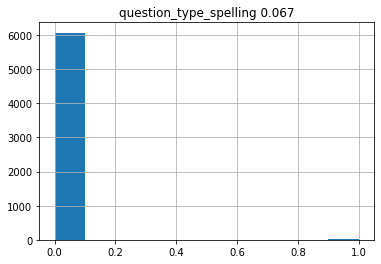

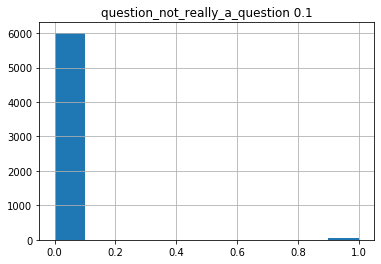

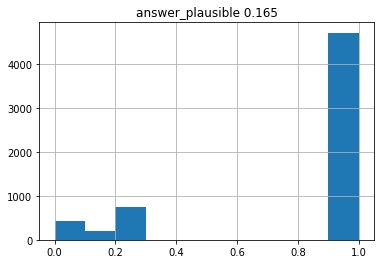

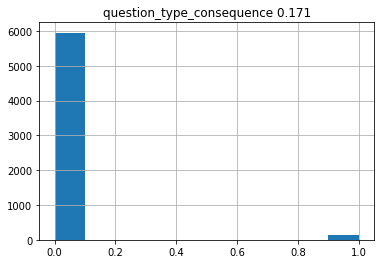

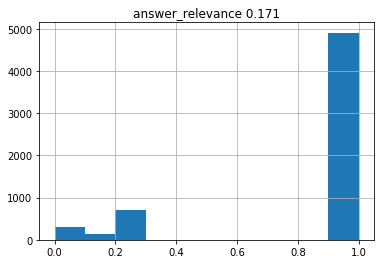

In [24]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


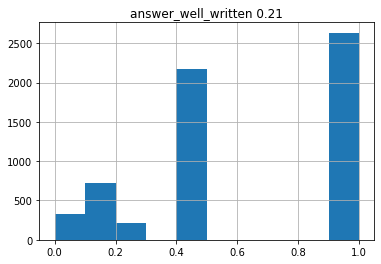

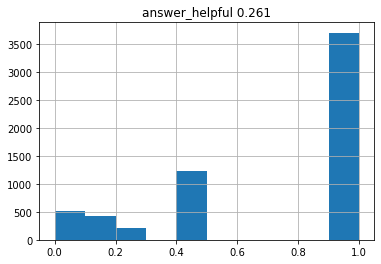

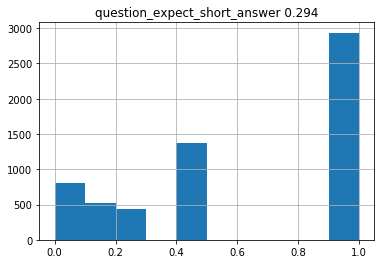

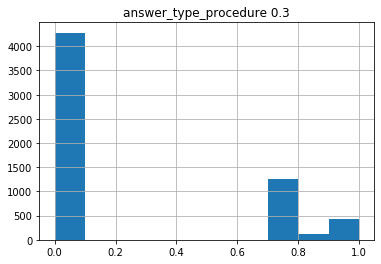

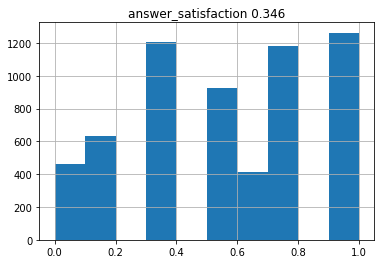

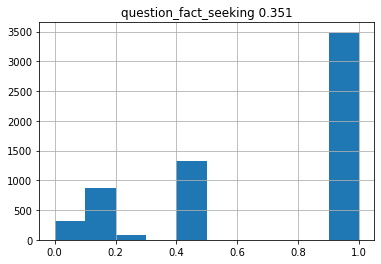

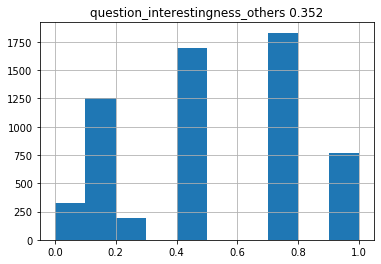

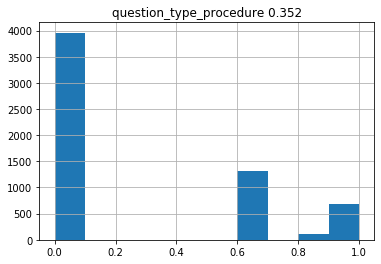

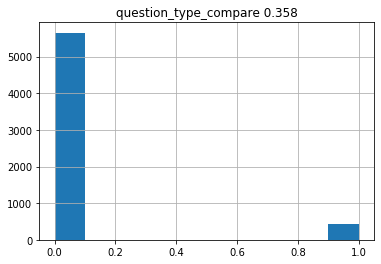

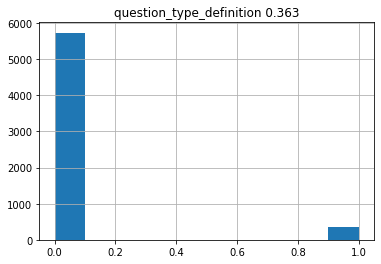

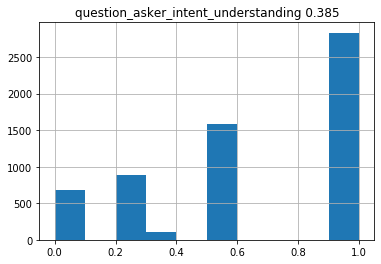

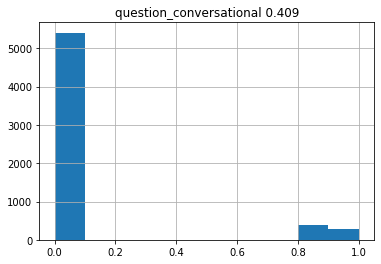

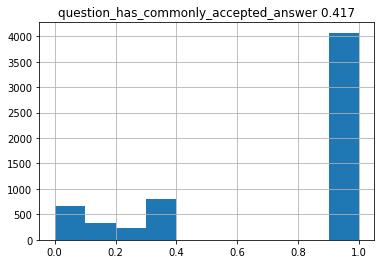

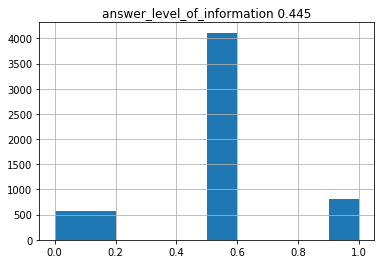

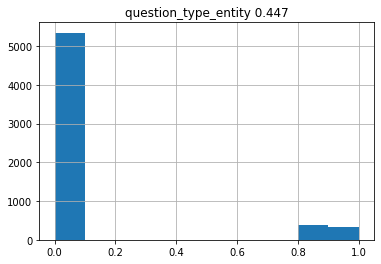

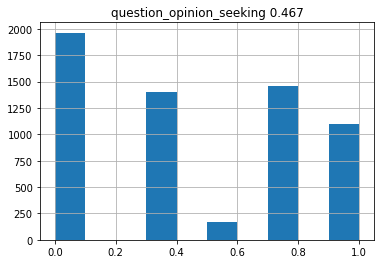

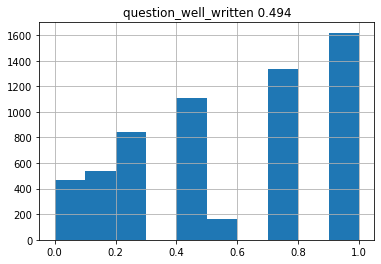

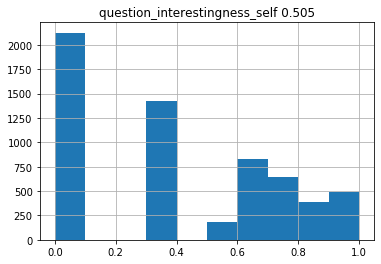

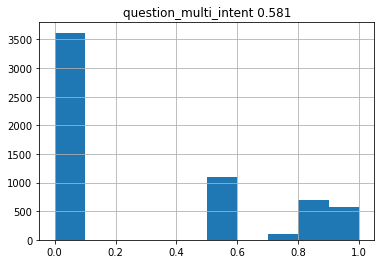

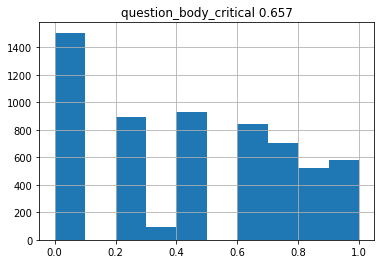

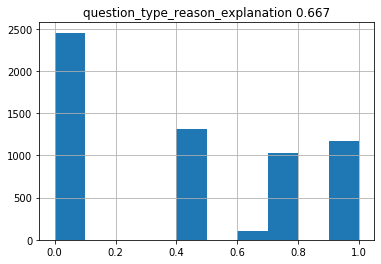

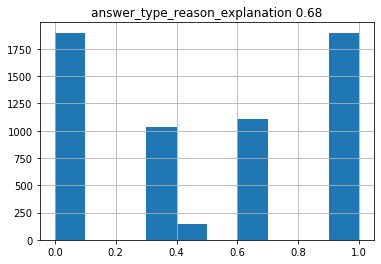

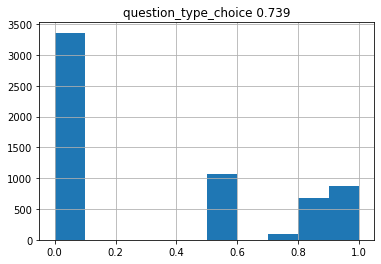

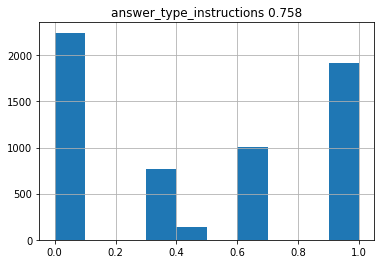

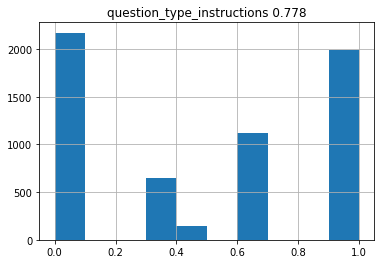

In [25]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')